## Maximizing returns with Portfolio Optimization

In [1]:
# !pip install PyPortfolioOpt -q

In [3]:
# Import the libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.risk_models import CovarianceShrinkage

In [15]:
# Create a function to get the stock data
def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

In [9]:
# Create a function to optimize the portfolio 
def optimize_portfolio(data):
    # Calculate the annualized expected returns based on historical data
    mu = mean_historical_return(data)
    # Calculate the covariance matrix using Ledoit-Wolf shrinkage for robustness
    S = CovarianceShrinkage(data).ledoit_wolf()
    # Initialize the Efficient Frontier Object
    ef = EfficientFrontier(mu, S)
    # Get the weights for the optimized portfolio
    weights = ef.max_sharpe()
    # Clean the weights
    cleaned_weights = ef.clean_weights()
    # Get the portfolio performance
    ef.portfolio_performance(verbose=True) # returns (expected return, volatility, Sharpe Ratio)

    # Extract the Sharpe Ratio
    sharpe_ratio = ef.portfolio_performance()[2]
    
    # Categorize the Sharpe Ratio
    if sharpe_ratio > 3.0:
        sharpe_evaluation = 'Exceptional'
    elif sharpe_ratio > 2.0:
        sharpe_evaluation = 'Excellent'
    elif sharpe_ratio > 1.0:
        sharpe_evaluation = 'Good'
    else:
        sharpe_evaluation = 'Suboptimal'

    print(f"\nSharpe Ratio Evaluation: ({sharpe_evaluation})")
    
    return cleaned_weights, mu, S

In [10]:
# Create a function to calculate the discrete allocation
def calculate_discrete_allocation(weights, data, total_portfolio_value):
    # Fetch the latest price
    latest_prices = get_latest_prices(data)
    # Initializing the Discrete Allocation object with weights and portfolio value
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = total_portfolio_value)
    # Calculate the number of shares to buy and the left over cash
    allocation, leftover = da.lp_portfolio()

    return allocation, leftover, latest_prices

In [33]:
# Create a function to visualize the results
def plot_results(weights, mu):
    plt.figure(figsize = (10,6))
    plt.style.use('dark_background')
    plt.bar(weights.keys(), weights.values(), color = 'cyan', edgecolor='white')
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.title('Optimized Portfolio Weights')
    # plt.xticks(color='black')
    # plt.yticks(color='white')
    plt.show()

In [17]:
# Execute the program

# Get the stock data

magnificent_seven = ['MSFT', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA', 'AAPL']

start_date = '2020-01-02'
end_date = '2025-01-01'

data = fetch_data(magnificent_seven, start_date, end_date)
data

/tmp/ipykernel_31883/1291236313.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,
2020-01-02,72.400528,94.900497,67.859543,208.324753,152.158432,5.971078,28.684000
2020-01-03,71.696648,93.748497,67.526535,207.222473,150.263779,5.875504,29.534000
2020-01-06,72.267929,95.143997,69.191551,211.125244,150.652161,5.900145,30.102667
2020-01-07,71.928040,95.343002,69.148376,211.582016,149.278580,5.971576,31.270666
2020-01-08,73.085114,94.598503,69.693291,213.727051,151.656326,5.982776,32.809334
...,...,...,...,...,...,...,...
2024-12-24,256.797241,229.050003,196.803833,605.839600,435.119751,140.181656,462.279999
2024-12-26,257.612701,227.050003,196.335663,601.453430,433.911407,139.891739,454.130005
2024-12-27,254.201385,223.750000,193.287521,597.924500,426.404083,136.972534,431.660004


Expected annual return: 83.7%
Annual volatility: 50.9%
Sharpe Ratio: 1.65

Sharpe Ratio Evaluation: (Good)

Optimized weights:
OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('GOOG', 0.0), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.82523), ('TSLA', 0.17477)])

Discrete Allocations:
NVDA: 615 shares, Total Cost: $82565.77
TSLA: 43 shares, Total Cost: $17365.12

Leftover Cash: $69.11


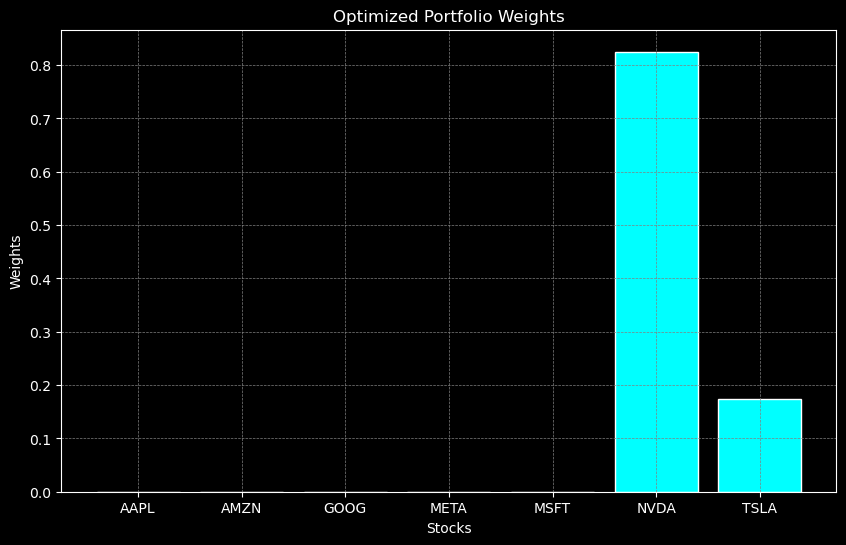

In [34]:
# Optimize the portfolio
weights, mu, S = optimize_portfolio(data)

# Define the total portfolio value
total_portfolio_value = 100000

# Calculate the discrete allocations
allocation, leftover, latest_prices = calculate_discrete_allocation(weights, data, total_portfolio_value)

# Print the optimized weights
print("\nOptimized weights:")
print(weights)

# Print the discrete allocations for each stock
print("\nDiscrete Allocations:")
for stock, shares in allocation.items():
    cost_per_share = latest_prices[stock]
    total_cost = shares * cost_per_share
    print(f'{stock}: {shares} shares, Total Cost: ${total_cost:.2f}')

# Print the leftover cash
print(f'\nLeftover Cash: ${leftover:.2f}')

# Plot the results
plot_results(weights, mu)